In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import data
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales_train = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dayfirst=True)
sample_submission = pd.read_csv('data/sample_submission.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

# Just some notes
Correlations, outliers, missing values, errors?
Predict for shop item pair in november 2015 the number of sales - in that month!

Factors:
- Period -> in some periods more is sold than in others
- Shop -> some shops sell more than others
- Item -> some items are being sold more than others
- Shop-item -> some shops sell item x more than other shops sell item x
- Period-shop -> some shops do better in certain periods
- Period-item -> some items do better in certain periods

In [4]:
# Augment data
sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year
sales_train['weekday'] = sales_train['date'].dt.day_of_week + 1
sales_train['total_price'] = sales_train['item_cnt_day'] * sales_train['item_price']
sales_train = pd.merge(sales_train, items[['item_id', 'item_category_id']], on='item_id')

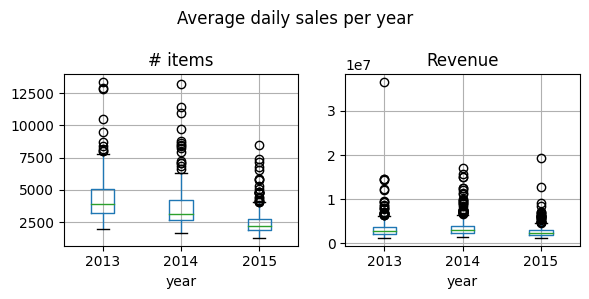

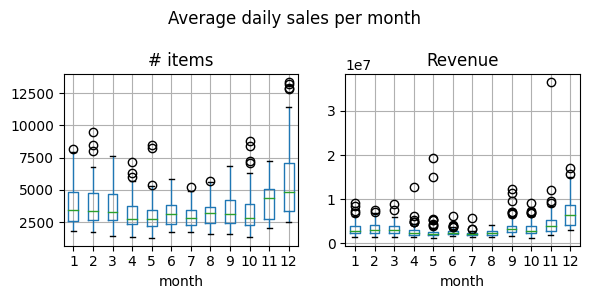

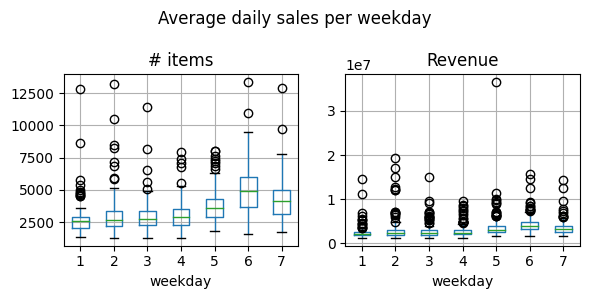

In [30]:
# Sales per time period
aggregation = {'total_price':'sum', 'item_cnt_day':'sum', 'year':'first', 'month':'first', 'weekday':'first'}
sales_per_day = sales_train.groupby('date', as_index=False).agg(aggregation)
for period in ['year', 'month', 'weekday']:
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    sales_per_day.boxplot(by=period, column=['item_cnt_day'], ax=ax[0])
    sales_per_day.boxplot(by=period, column=['total_price'], ax=ax[1])
    ax[0].set_title('# items')
    ax[1].set_title('Revenue')
    fig.suptitle('Average daily sales per ' + period)
    fig.tight_layout(rect=[0,0,1,1])

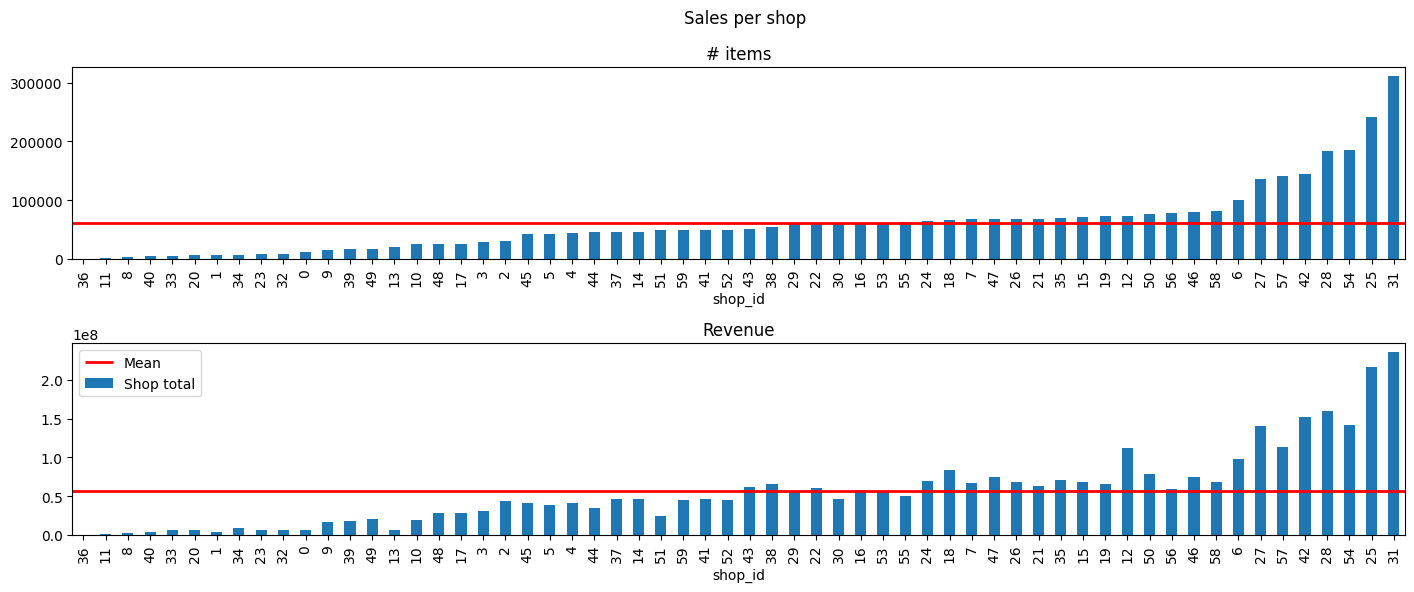

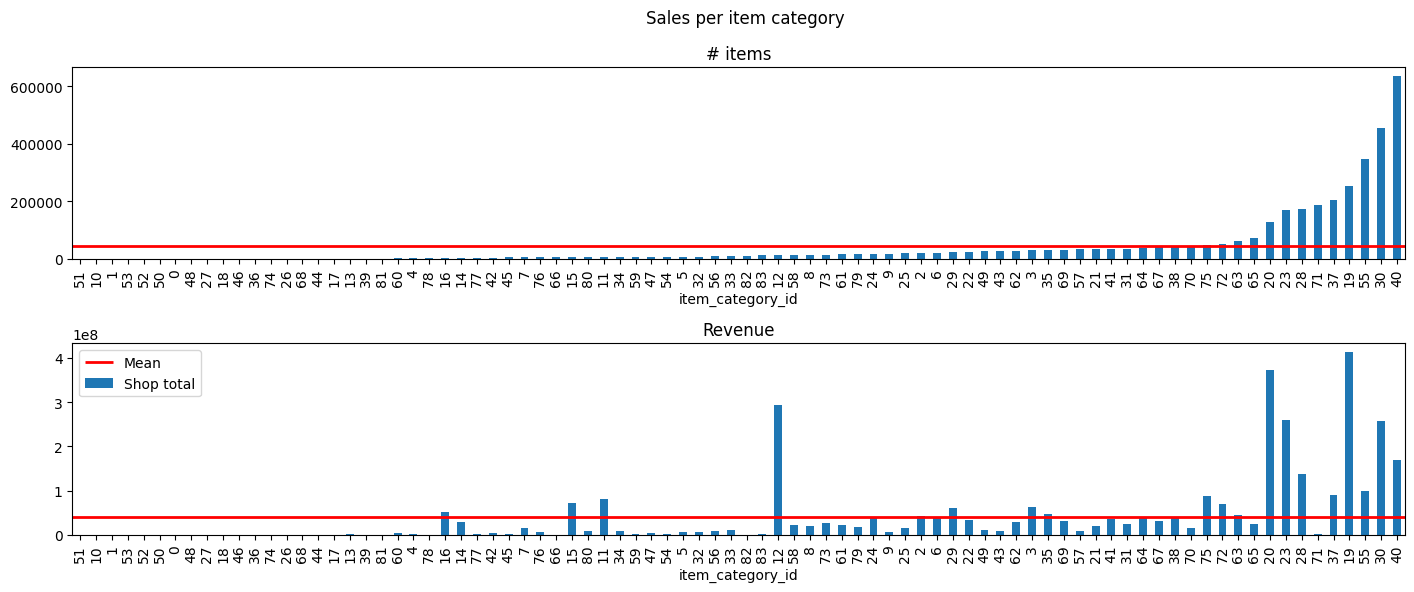

In [66]:
measure = ['item_cnt_day', 'total_price']
title = ['# items', 'Revenue']
groups = {'shop_id':'shop', 'item_category_id':'item category'}

for group in groups:
    fig, ax = plt.subplots(2, 1, figsize=(15,6))
    for i in range(2):
        item_sells_count_per_shop = sales_train.groupby(group).sum()[measure[i]]
        ax[i].hlines( item_sells_count_per_shop.mean(), xmin=-1, xmax=100, linewidth=2, color='r',label='Mean')
        if i == 0:
            indices = item_sells_count_per_shop.argsort()
        item_sells_count_per_shop.iloc[indices].plot.bar(label= "Shop total", ax=ax[i])
        ax[i].set_title(title[i])
    fig.suptitle('Sales per ' + groups[group])
    fig.tight_layout(rect=[0,0,0.95,1])
    plt.legend()

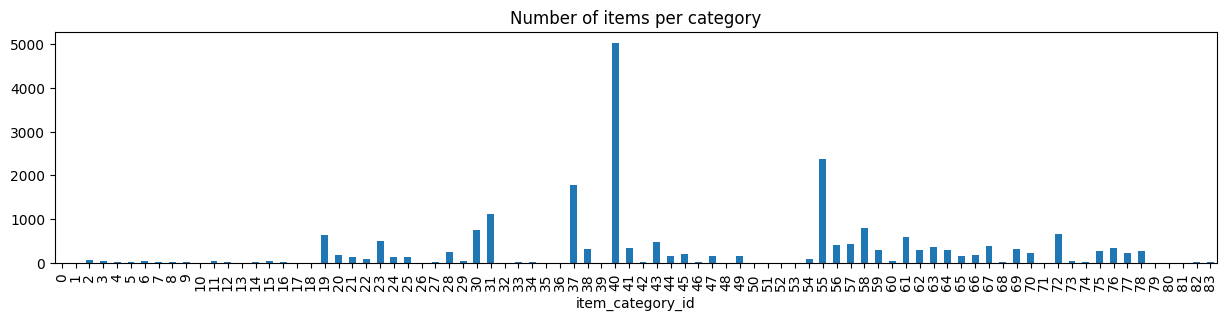

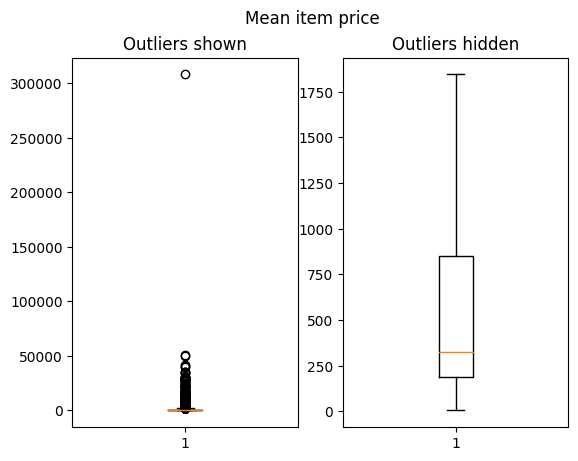

Items which are returned more than sold, or not sold at all:
         item_price  item_cnt_day  total_price
item_id                                       
1590        2599.00         -11.0     -28589.0
4591         399.00           0.0          0.0
7547        3390.00           0.0          0.0
8515         141.55           0.0         14.9
11871       5999.00          -1.0      -5999.0
13474      10398.00          -1.0     -10398.0
13477      10194.00           0.0      -7592.0
18062       4999.00          -1.0      -4999.0


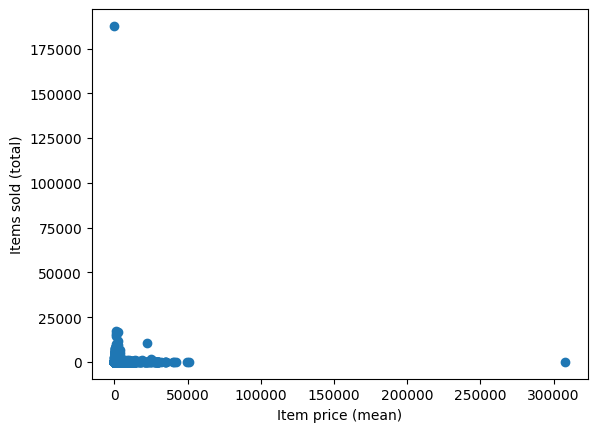

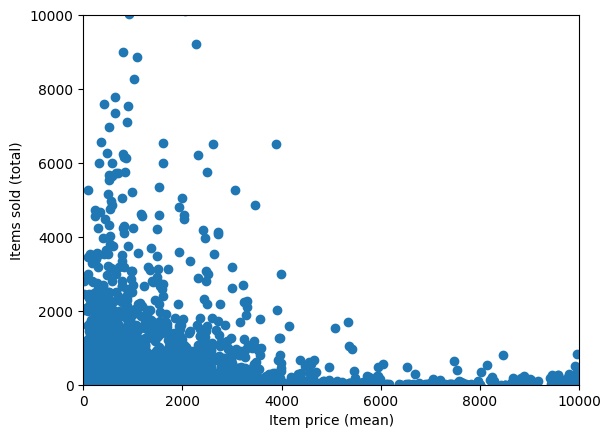

Corelation between item price and sales count:
              item_cnt_day  item_price
item_cnt_day      1.000000    0.004903
item_price        0.004903    1.000000


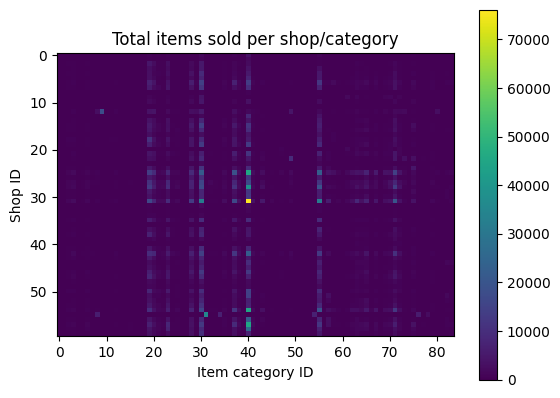

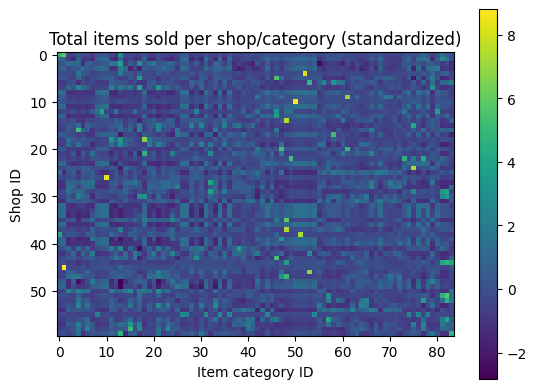

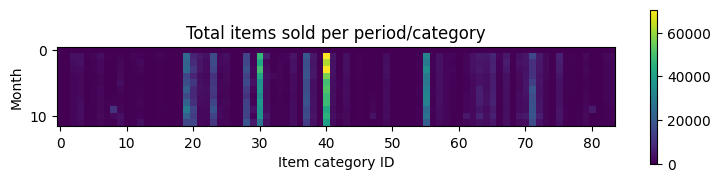

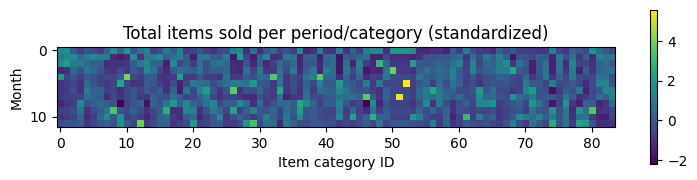

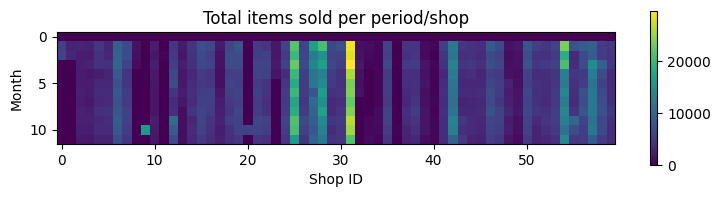

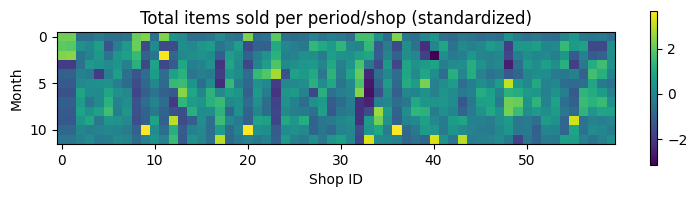

In [127]:
# Item information
aggregation = {'item_price':'mean', 'item_cnt_day':'sum', 'total_price':'sum'}
sales_per_item = pd.merge(items, sales_train, on='item_id').groupby('item_id').agg(aggregation)
items_per_categories = items.groupby('item_category_id').count()['item_name'].plot.bar(figsize=(15,3), title='Number of items per category')
plt.show()

plt.subplot(1,2,1)
plt.boxplot(sales_per_item['item_price'])
plt.title("Outliers shown")
plt.subplot(1,2,2)
plt.boxplot(sales_per_item['item_price'], showfliers=False)
plt.title("Outliers hidden")
plt.suptitle("Mean item price")
plt.show()

print("Items which are returned more than sold, or not sold at all:")
print(sales_per_item[sales_per_item['item_cnt_day'] <= 0])

plt.scatter(sales_per_item['item_price'], sales_per_item['item_cnt_day'])
plt.xlabel('Item price (mean)')
plt.ylabel('Items sold (total)')
plt.show()

plt.scatter(sales_per_item['item_price'], sales_per_item['item_cnt_day'])
plt.xlabel('Item price (mean)')
plt.ylabel('Items sold (total)')
plt.xlim((0,10000))
plt.ylim((0,10000))
plt.show()

print("Corelation between item price and sales count:")
print(sales_per_item[['item_cnt_day', 'item_price']].corr())

#TODO extract and interpret the outliers

def standardize(matrix, cols=True, rows=True):
    if cols:
        col_mean = matrix.mean(axis=0)
        col_std = matrix.std(axis=0)
        matrix = (matrix - col_mean[np.newaxis, :]) / col_std[np.newaxis, :]
    if rows:
        row_mean = matrix.mean(axis=1)
        row_std = matrix.std(axis=1)
        matrix = (matrix - row_mean[:, np.newaxis]) / row_std[:, np.newaxis] 
    return matrix

shop_itemcat = sales_train.groupby(['shop_id', 'item_category_id'], as_index=False).sum()
mat = np.zeros((60, 84))
for i in range(60):
    for j in range(84):
        total_cnt = shop_itemcat[(shop_itemcat['shop_id']==i) & (shop_itemcat['item_category_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

settings = [[False, False, ''], 
            # [False, True, ' (categories standardized)'], 
            # [True, False, ' (shops standardized)'], 
            [True, True, ' (standardized)']]

for setting in settings:
    plt.imshow(standardize(mat.copy(), rows=setting[0], cols=setting[1]))
    plt.xlabel('Item category ID')
    plt.ylabel('Shop ID')
    plt.title('Total items sold per shop/category' + setting[2])
    plt.colorbar()
    plt.show()

period_itemcat = sales_train.groupby(['month', 'item_category_id'], as_index=False).sum()
mat = np.zeros((12, 84))
for i in range(12):
    for j in range(84):
        total_cnt = period_itemcat[(period_itemcat['month']==i) & (period_itemcat['item_category_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

settings = [[False, False, ''], 
            # [False, True, ' (categories standardized)'], 
            # [True, False, ' (months standardized)'], 
            [True, True, ' (standardized)']]

for i in range(len(settings)):
    plt.figure(figsize=(9,2))
    plt.imshow(standardize(mat.copy(), rows=settings[i][0], cols=settings[i][1]))
    plt.xlabel('Item category ID')
    plt.ylabel("Month")
    plt.title("Total items sold per period/category" + settings[i][2])
    plt.colorbar()
    plt.show()

period_shop = sales_train.groupby(['month', 'shop_id'], as_index=False).sum()
mat = np.zeros((12, 60))
for i in range(12):
    for j in range(60):
        total_cnt = period_shop[(period_shop['month']==i) & (period_shop['shop_id']==j)]['item_cnt_day']
        if not total_cnt.empty:
            mat[i,j] = total_cnt

settings = [[False, False, ''], 
            # [False, True, ' (shops standardized)'], 
            # [True, False, ' (months standardized)'], 
            [True, True, ' (standardized)']]

for i in range(len(settings)):
    plt.figure(figsize=(9,2))
    plt.imshow(standardize(mat.copy(), rows=settings[i][0], cols=settings[i][1]))
    plt.xlabel('Shop ID')
    plt.ylabel("Month")
    plt.title("Total items sold per period/shop" + settings[i][2])
    plt.colorbar()
    plt.show()

# But will our 'model' use item category?...

In [128]:
# SOME OLD STUFF
# mean = sales_train.groupby('shop_id', as_index=False).mean()[['shop_id', 'total_price', 'item_cnt_day']]
# std = sales_train.groupby('shop_id', as_index=False).std()[['shop_id', 'total_price', 'item_cnt_day']]
# mean = mean.rename(columns={"total_price": "mean_total_price", "item_cnt_day": "mean_item_cnt_day"})
# std = std.rename(columns={"total_price": "std_total_price", "item_cnt_day": "std_item_cnt_day"})

# sales_train = sales_train.merge(mean, on='shop_id')
# sales_train = sales_train.merge(std, on='shop_id')
# sales_train['normalized_total_price'] = (sales_train['total_price'] - sales_train['mean_total_price']) / sales_train['std_total_price']
# sales_train['normalized_cnt_day'] = (sales_train['item_cnt_day'] - sales_train['mean_item_cnt_day']) / sales_train['std_item_cnt_day']

# sales_per_month = sales_train.groupby(['month']).sum()
# plt.bar(sales_per_month.index, sales_per_month['normalized_cnt_day'])
# plt.show()
# plt.bar(sales_per_month.index, sales_per_month['item_cnt_day'])
# plt.show()

# # Visualize data
# for index, row in shops.iterrows():
#     shop_id = row['shop_id']
#     sales_per_month = sales_train[sales_train['shop_id'] == shop_id].groupby(['month']).sum()
#     plt.bar(sales_per_month.index, sales_per_month['item_cnt_day'])
#     plt.title('Shop ' + str(shop_id) + ', monthly transaction count')
#     plt.show()